
# 03. Auditoria y Finanzas (La Defensa Académica)

Este notebook realiza una validación rigurosa del modelo utilizando **datos fuera de tiempo (Out-of-Time Validation)**.
Nos centramos exclusivamente en la temporada **2023-2024** para simular el rendimiento real del modelo en un entorno de producción.

**Objetivos:**
1.  **Evaluación Técnica**: Log Loss, Accuracy y Matriz de Confusión en el conjunto de Test.
2.  **Evaluación Financiera (Prueba de Fuego)**: Simulación de una estrategia de apuestas basada en valor (Value Betting) para determinar la rentabilidad (ROI) real.


In [20]:

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score

# Configuración Visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Archivos
INPUT_FILE = '../df_final_app.csv'
MODEL_FILE = '../modelo_city_group.joblib'


In [21]:

print(" Cargando datos y modelo...")

# Cargar Datos
try:
    df = pd.read_csv(INPUT_FILE)
    df['Date'] = pd.to_datetime(df['Date'])
    print(f" Datos cargados: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f" No se encuentra {INPUT_FILE}. Ejecuta NB01 primero.")

# Cargar Modelo
try:
    artifact = joblib.load(MODEL_FILE)
    
    # Inicializar scaler por defecto
    scaler = None
    
    # Detectar tipo de artefacto (Diccionario o Modelo directo)
    if isinstance(artifact, dict):
        print(" El archivo es un artefacto completo (dict).")
        model = artifact['model']
        features = artifact.get('features', [])
        le = artifact.get('label_encoder', artifact.get('le', None))
        scaler = artifact.get('scaler', None)
    else:
        print(" El archivo es el modelo directo (XGBClassifier).")
        model = artifact
        # Definir features manualmente si no vienen en el archivo (fallback)
        features = [
            "Home_Elo", "Away_Elo",
            "Home_xG_Avg_L5", "Away_xG_Avg_L5",
            "Home_Streak_L5", "Away_Streak_L5",
            "Home_Pressure_Avg_L5", "Away_Pressure_Avg_L5",
            "Home_Dominance_Avg_L5", "Away_Dominance_Avg_L5"
        ]
        le = None

    # Label Encoder Fallback
    if le is None:
        print(" LabelEncoder no encontrado. Creando uno nuevo...")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        le.fit(df['FTR']) 
        print(f" LabelEncoder recreado: {le.classes_}")
    else:
        print(f" LabelEncoder cargado: {le.classes_}")

    print(f" Modelo cargado: {type(model).__name__}")
    
except FileNotFoundError:
    raise FileNotFoundError(f" No se encuentra {MODEL_FILE}. Ejecuta NB02 primero.")
except Exception as e:
    raise Exception(f" Error cargando el modelo: {str(e)}")


 Cargando datos y modelo...
 Datos cargados: (8360, 20)
 El archivo es el modelo directo (XGBClassifier).
 LabelEncoder no encontrado. Creando uno nuevo...
 LabelEncoder recreado: ['A' 'D' 'H']
 Modelo cargado: XGBClassifier


In [22]:

print(" Generando Split de Test (Temporada 2023)...")

# Filtrar Datos de Test
df_test = df[df['Season'] == 2023].copy().reset_index(drop=True)

if df_test.empty:
    raise ValueError(" El conjunto de test (Season 2023) está vacío. Verifica los datos.")

X_test = df_test[features]
y_test_labels = df_test['FTR']
y_test = le.transform(y_test_labels)

# Escalar si es necesario (XGBoost no lo requiere estrictamente, pero si se usó scaler en NB02...)
if scaler:
    print(" Aplicando escalado a los datos de test...")
    X_test_scaled = scaler.transform(X_test)
else:
    X_test_scaled = X_test

print(f" Conjunto de Test generado: {X_test.shape[0]} partidos.")
print("   Distribución Real:", df_test['FTR'].value_counts(normalize=True).to_dict())


 Generando Split de Test (Temporada 2023)...
 Conjunto de Test generado: 380 partidos.
   Distribución Real: {'H': 0.4394736842105263, 'D': 0.28157894736842104, 'A': 0.2789473684210526}


 Generando Predicciones...

 RESULTADOS TÉCNICOS (Season 2023):
   Log Loss: 0.9424 (Menor es mejor)
   Accuracy: 0.5316

 Classification Report:
              precision    recall  f1-score   support

           A       0.51      0.51      0.51       106
           D       0.50      0.01      0.02       107
           H       0.54      0.88      0.67       167

    accuracy                           0.53       380
   macro avg       0.52      0.47      0.40       380
weighted avg       0.52      0.53      0.44       380



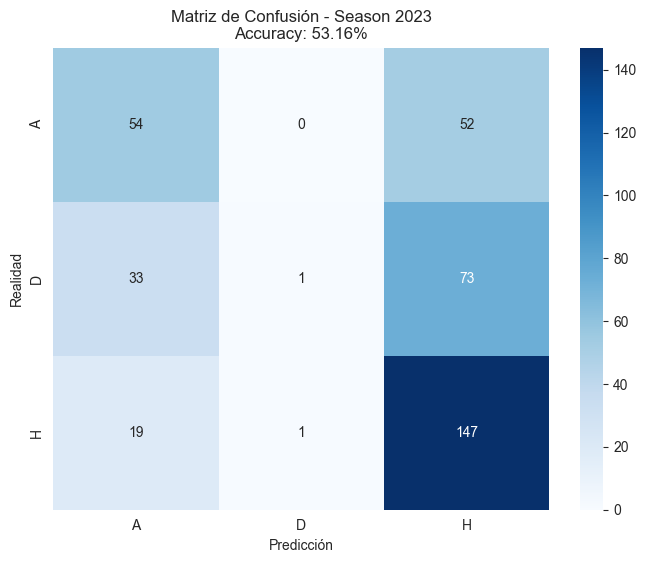

In [23]:

print(" Generando Predicciones...")

# Predecir Probabilidades
probs = model.predict_proba(X_test_scaled)
preds = model.predict(X_test_scaled)

# Métricas
loss = log_loss(y_test, probs)
acc = accuracy_score(y_test, preds)

print(f"\n RESULTADOS TÉCNICOS (Season 2023):")
print(f"   Log Loss: {loss:.4f} (Menor es mejor)")
print(f"   Accuracy: {acc:.4f}")

# Reporte de Clasificación
print("\n Classification Report:")
target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_test, preds, target_names=target_names))

# Matriz de Confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Matriz de Confusión - Season 2023\nAccuracy: {acc:.2%}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()


 CALCULANDO RENTABILIDAD (ROI) 
 Índices de clases: H=2, D=1, A=0

 RESULTADOS FINANCIEROS:
   Apuestas Realizadas: 258
   Bankroll Final: 703.00u (Inicial: 1000u)
   Beneficio Neto: -297.00u
   ROI: -29.70%


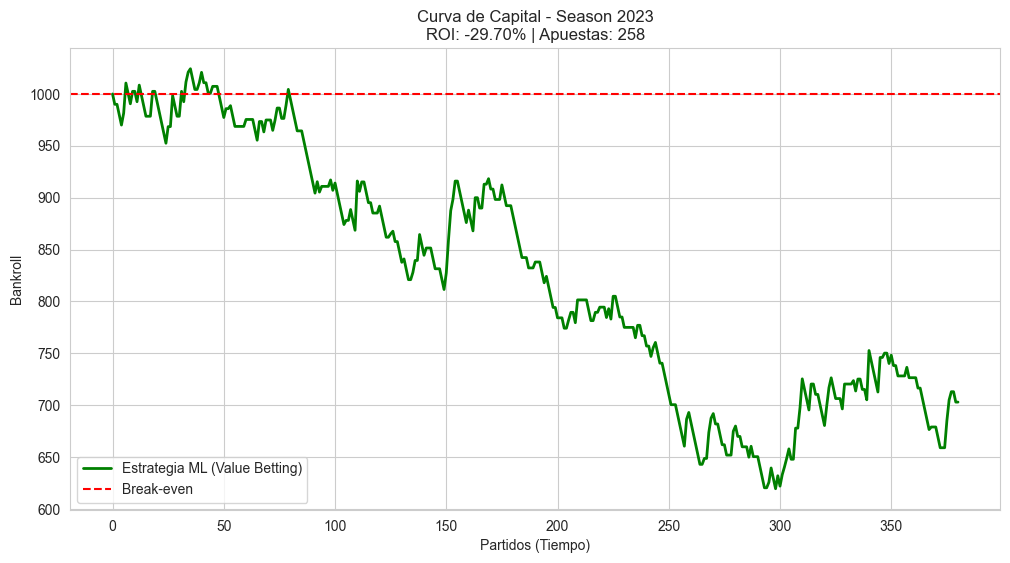

In [24]:

print(" CALCULANDO RENTABILIDAD (ROI) ")

# Configuración de Estrategia
INITIAL_BANK = 1000
STAKE_FIXED = 10  # Apuesta plana de 10 unidades
MIN_EV = 0.05     # Margen de valor mínimo (5%) para apostar

bankroll = [INITIAL_BANK]
bets_history = []

# Mapear probabilidades al DataFrame
# Orden de clases en probs depende de le.classes_. Usualmente orden alfabético: A, D, H o similar.
# Verificamos clases:
classes = le.classes_
idx_h = np.where(classes == 'H')[0][0]
idx_d = np.where(classes == 'D')[0][0]
idx_a = np.where(classes == 'A')[0][0]

print(f" Índices de clases: H={idx_h}, D={idx_d}, A={idx_a}")

for i, row in df_test.iterrows():
    # Probabilidades del modelo
    p_home = probs[i][idx_h]
    p_draw = probs[i][idx_d]
    p_away = probs[i][idx_a]
    
    # Cuotas (Asumimos columnas B365H, B365D, B365A existen)
    # Si no, usamos AvgH, AvgD, AvgA
    try:
        odd_h = row.get('B365H', row.get('AvgH', 0))
        odd_d = row.get('B365D', row.get('AvgD', 0))
        odd_a = row.get('B365A', row.get('AvgA', 0))
    except:
        continue # Si no hay cuotas, saltamos
        
    if odd_h == 0: continue

    # Calcular Valor Esperado (EV) = (Prob * Cuota) - 1
    ev_h = (p_home * odd_h) - 1
    ev_d = (p_draw * odd_d) - 1
    ev_a = (p_away * odd_a) - 1
    
    # Seleccionar la mejor apuesta
    best_ev = max(ev_h, ev_d, ev_a)
    result = row['FTR']
    
    profit = 0
    bet_type = None
    
    if best_ev > MIN_EV:
        if best_ev == ev_h:
            bet_type = 'H'
            if result == 'H': profit = (STAKE_FIXED * odd_h) - STAKE_FIXED
            else: profit = -STAKE_FIXED
        elif best_ev == ev_d:
            bet_type = 'D'
            if result == 'D': profit = (STAKE_FIXED * odd_d) - STAKE_FIXED
            else: profit = -STAKE_FIXED
        else:
            bet_type = 'A'
            if result == 'A': profit = (STAKE_FIXED * odd_a) - STAKE_FIXED
            else: profit = -STAKE_FIXED
            
        bankroll.append(bankroll[-1] + profit)
        bets_history.append({
            'Date': row['Date'],
            'Match': f"{row['HomeTeam']} vs {row['AwayTeam']}",
            'Bet': bet_type,
            'Odd': odd_h if bet_type=='H' else odd_d if bet_type=='D' else odd_a,
            'Result': result,
            'Profit': profit,
            'Bankroll': bankroll[-1]
        })
    else:
        # Si no se apuesta, el bankroll se mantiene
        bankroll.append(bankroll[-1])

# Métricas Finales
final_bank = bankroll[-1]
total_profit = final_bank - INITIAL_BANK
roi = (total_profit / INITIAL_BANK) * 100
n_bets = len(bets_history)

print(f"\n RESULTADOS FINANCIEROS:")
print(f"   Apuestas Realizadas: {n_bets}")
print(f"   Bankroll Final: {final_bank:.2f}u (Inicial: {INITIAL_BANK}u)")
print(f"   Beneficio Neto: {total_profit:.2f}u")
print(f"   ROI: {roi:.2f}%")

# Gráfico de Curva de Capital
plt.figure(figsize=(12, 6))
plt.plot(bankroll, label='Estrategia ML (Value Betting)', color='green', linewidth=2)
plt.axhline(y=INITIAL_BANK, color='red', linestyle='--', label='Break-even')
plt.title(f'Curva de Capital - Season 2023\nROI: {roi:.2f}% | Apuestas: {n_bets}')
plt.xlabel('Partidos (Tiempo)')
plt.ylabel('Bankroll')
plt.legend()
plt.show()
